In [1]:
import pandas as pd
import openpyxl
import numpy as np
import os
import glob2
import glob
import random
import sklearn
import ntpath
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from nltk.test.portuguese_en_fixt import setup_module
import nltk
from contextlib import nullcontext
import unicodedata
import plotly
import read_file_exec as rfe

In [40]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(42)

## Puxada dos dados modelados do processo de extração

In [2]:
modelo_inventario = rfe.read_file('etl_results/tempo_em_estoque.xlsx').get_df()
modelo_transac_prod = rfe.read_file('etl_results/transacoes_produto_tratado_final.xlsx').get_df()

## Dados de Inventário

In [3]:
modelo_inventario


codigo                                 descricao  categoria  \
0     7100692                APLIQUE - APM4 -053 NOIVOS  papelaria   
1      099939  MASSA BISCUIT acrilex 90G - AMARELO PELE  papelaria   
2      099935   MASSA BISCUIT acrilex 90G - VERDE MUSGO  papelaria   
3      099993                     PINCEL TIGRE 815 - 04  papelaria   
4      099996                     PINCEL TIGRE 815 - 10  papelaria   
...       ...                                       ...        ...   
5116  7100714             PANO DE COPA NATAL PAPAI NOEL    enxoval   
5117   099804                                  TNT AZUL     tecido   
5118   123594                    LÃ BADEN - 20 VERMELHO         la   
5119   099599                         LÃ COLORPULL 8663         la   
5120   099593                          LÃ MAGNUM MARROM         la   

      estoque_disponivel  preco             incluido_em  \
0                    9.0    2.5 2020-11-16 17:19:42.000   
1                    0.0    4.5 2020-03-12 09:25:38.569   
2                    0.0    4.5 2020-03-12 09:11:30.999   
3                    3.0    3.5 2020-03-12 16:23:51.521   
4                    4.0    5.0 2020-03-12 16:28:07.014   
...                  ...    ...                     ...   
5116                 0.0    9.5 2020-11-24 10:09:39.995   
5117                 4.0    2.0 2020-03-07 08:19:00.682   
5118                 4.0   22.0 2020-04-02 13:03:35.661   
5119                 0.0   30.0 2020-03-05 09:03:44.801   
5120                 3.0   30.0 2020-03-05 08:45:28.169   

                 alterado_em   ncm  taxa_depreciacao  ano_mes  ...  \
0    2021-04-13 15:15:27.708  3926                 0  2021-04  ...   
1    2021-04-13 14:54:44.957  3926                 0  2021-04  ...   
2    2021-04-13 14:55:19.701  3926                 0  2021-04  ...   
3    2021-04-30 17:10:25.288  3926                 0  2021-04  ...   
4    2021-04-30 17:11:11.816  3926                 0  2021-04  ...   
...                      ...   ...               ...      ...  ...   
5116 2022-01-15 10:33:43.065  6303                20  2022-01  ...   
5117 2020-04-29 14:49:39.436  6303                20  2020-04  ...   
5118 2020-04-02 13:03:35.661  6303                20  2020-04  ...   
5119 2020-04-29 14:47:21.646  6303                20  2020-04  ...   
5120 2020-04-20 13:20:24.581  6303                20  2020-04  ...   

                      clf_estoque  fator_atualizacao  depreciacao_unit  \
0              Produto no estoque           0.761290          0.000000   
1     Produto não está em estoque           1.000000          0.000000   
2     Produto não está em estoque           1.000000          0.000000   
3              Produto no estoque           0.523590          0.000000   
4              Produto no estoque           0.523590          0.000000   
...                           ...                ...               ...   
5116  Produto não está em estoque           1.000000          0.000000   
5117           Produto no estoque           0.938286          0.053687   
5118      Risco de estoque parado           1.000000          0.524315   
5119  Produto não está em estoque           1.000000          0.805307   
5120           Produto no estoque           0.946408          0.773995   

      fator_correcao  correcao_unit  correcao_deprec depreciacao  valor_ini  \
0           1.126423       2.816058         2.816058    0.000000       22.5   
1           1.126423       5.068904         5.068904    0.000000        0.0   
2           1.126423       5.068904         5.068904    0.000000        0.0   
3           1.126423       3.942481         3.942481    0.000000       10.5   
4           1.126423       5.632116         5.632116    0.000000       20.0   
...              ...            ...              ...         ...        ...   
5116        1.042070       9.899664         5.894360    0.000000        0.0   
5117        1.202562       2.405123         2.351436    0.214748        8.0   
5118        1.20

In [4]:
modelo_transac_prod 

tipo  numero                    data  \
0          Ajuste de Custo   38041 2022-07-20 17:40:01.564   
1      Ajuste de Estoque +   38040 2022-07-20 17:40:01.374   
2          Ajuste de Custo   36992 2022-06-16 10:35:44.146   
3      Ajuste de Estoque +   36991 2022-06-16 10:35:43.968   
4                    Venda   36767 2022-06-09 10:42:36.640   
...                    ...     ...                     ...   
47447  Ajuste de Estoque +       7 2020-02-03 13:31:23.044   
47448      Ajuste de Custo       6 2020-02-03 13:29:52.455   
47449  Ajuste de Estoque +       5 2020-02-03 13:29:52.440   
47450      Ajuste de Custo       4 2020-02-03 13:27:48.967   
47451  Ajuste de Estoque +       3 2020-02-03 13:27:48.958   

                         hora                        produto  quant_  \
0     2022-07-20 17:40:01.564  LINHA CLÉA 125 -5899 PANTANAL     0.0   
1     2022-07-20 17:40:01.374  LINHA CLÉA 125 -5899 PANTANAL    10.0   
2     2022-06-16 10:35:44.146       AGULHA CROCHE LULI - 5,5     0.0   
3     2022-06-16 10:35:43.968       AGULHA CROCHE LULI - 5,5    12.0   
4     2022-06-09 10:42:36.640        PAPEL DECOUPAGE-AFQ-032    -1.0   
...                       ...                            ...     ...   
47447 2020-02-03 13:31:23.044            Linha Rayza - Cinza     9.0   
47448 2020-02-03 13:29:52.455          Linha Rayza - Laranja     0.0   
47449 2020-02-03 13:29:52.440          Linha Rayza - Laranja     5.0   
47450 2020-02-03 13:27:48.967   Linha Rayza - Verde Bandeira     0.0   
47451 2020-02-03 13:27:48.958   Linha Rayza - Verde Bandeira     9.0   

       vl__unitario  sub_total  desconto  outras_despesas gerado_clf_auto  \
0              9.25        0.0       0.0                0               S   
1              0.00        0.0       0.0                0               S   
2              3.00        0.0       0.0                0               S   
3              0.00        0.0       0.0                0               S   
4              3.00        3.0       0.0                0               S   
...             ...        ...       ...              ...             ...   
47447          0.00        0.0       0.0                0               N   
47448          5.50        0.0       0.0                0               N   
47449          0.00        0.0       0.0                0               N   
47450          5.50        0.0       0.0                0               N   
47451          0.00        0.0       0.0                0               N   

       total    codigo  categoria  
0        0.0  85922412      linha  
1        0.0  15042603      linha  
2        0.0   3456886  armarinho  
3        0.0  99629223  armarinho  
4        3.0  37013810  papelaria  
...      ...       ...        ...  
47447    0.0     98012      linha  
47448    0.0     98033      linha  
47449    0.0     98033      linha  
47450    0.0     98043      linha  
47451    0.0     98043      linha  

[47452 rows x 14 columns]

<Figure size 640x480 with 0 Axes>

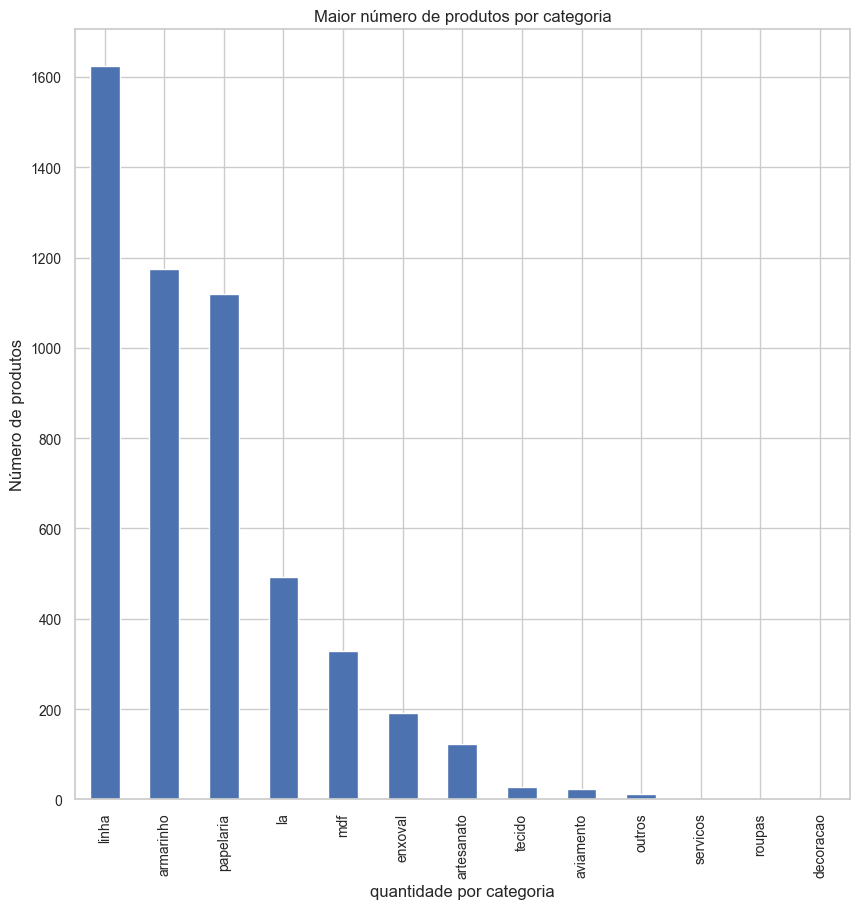

In [41]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots()

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)


plot_rank_categoria = modelo_inventario['categoria'].value_counts().plot(kind='bar', title='Maior número de produtos por categoria',figsize=(10,10))
plot_rank_categoria.set_xlabel('quantidade por categoria')
plot_rank_categoria.set_ylabel('Número de produtos')
plt.show()

In [42]:
classificacao_inv = modelo_inventario.groupby('clf_estoque').agg({'categoria': 'nunique', 'codigo': 'count'})
classificacao_inv.head()

categoria  codigo
clf_estoque                                            
Produto alterado no último trimestre         10     186
Produto no estoque                            9    3130
Produto não está em estoque                  12     927
Risco de estoque parado                      10     878

<Figure size 640x480 with 0 Axes>

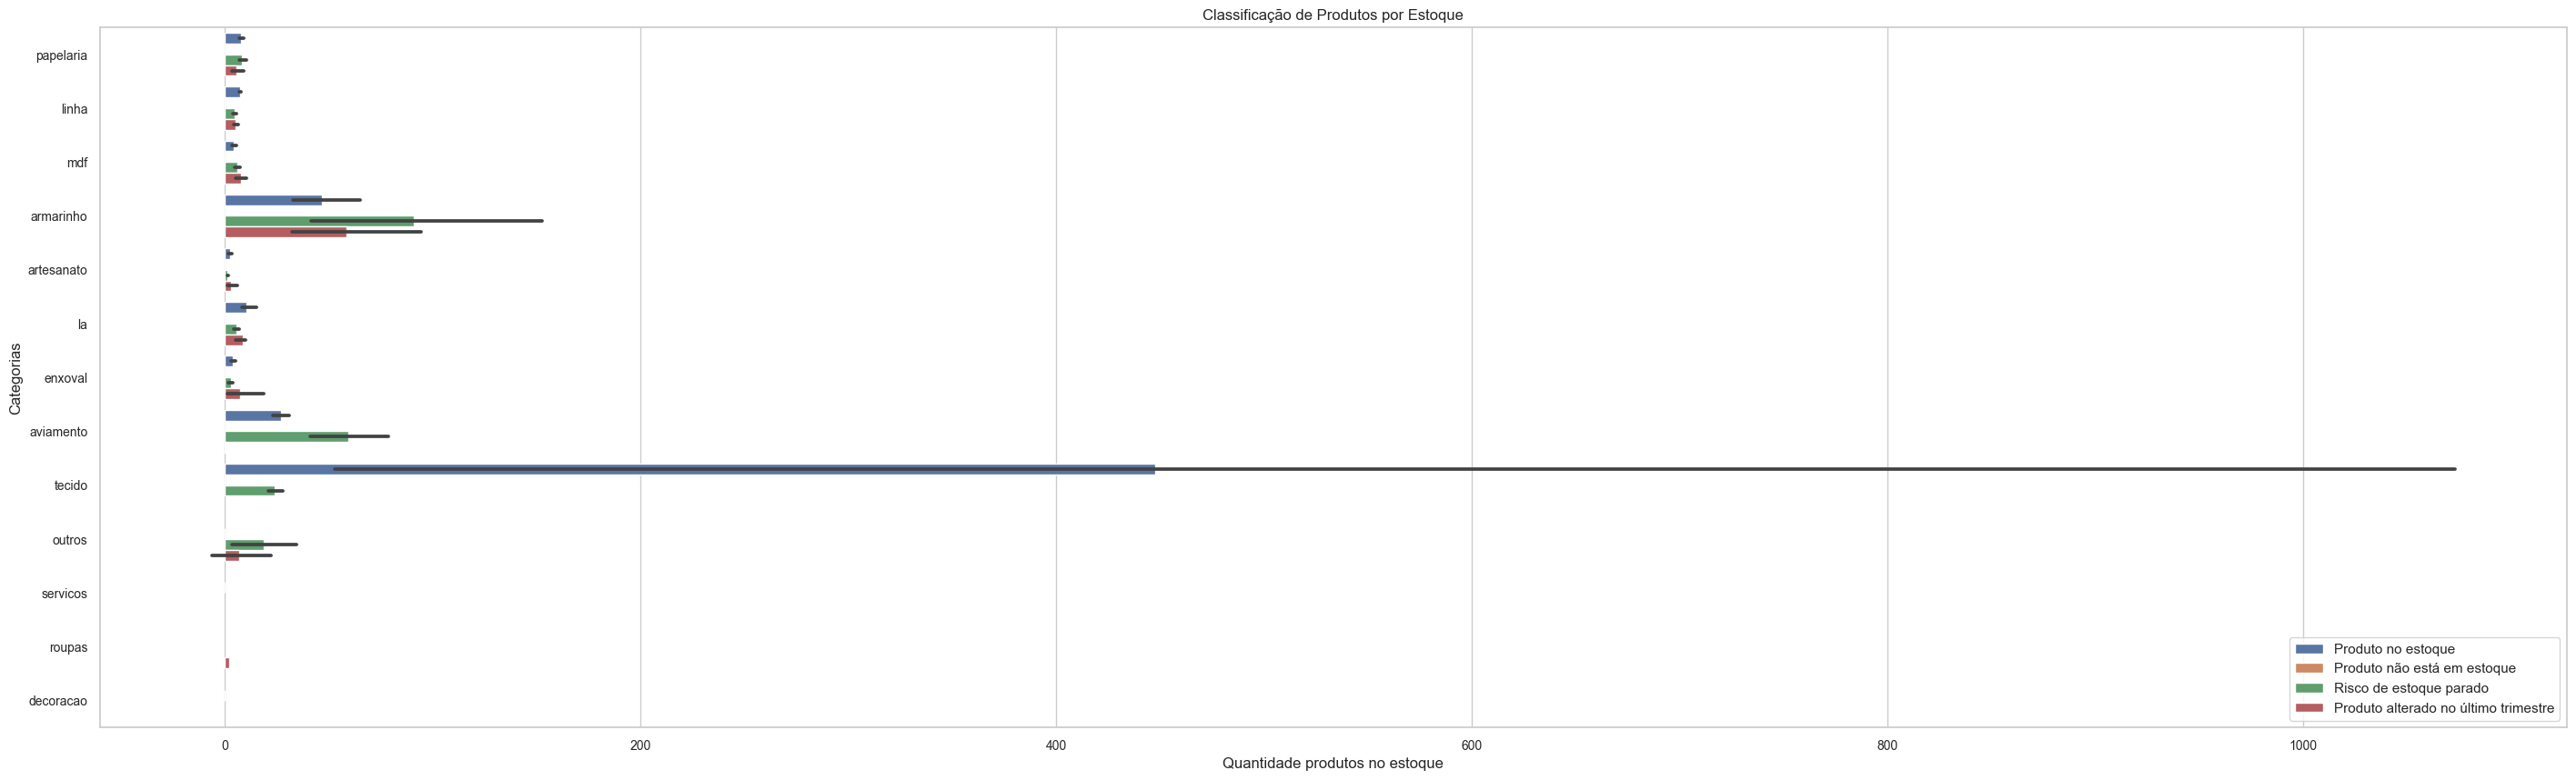

<Figure size 2000x2000 with 0 Axes>

In [43]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (35,10)
fig, ax = plt.subplots()

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

#plot by clf_estoque from tempo_em_estoque

plot_classificacao_inv = sns.barplot(x='estoque_disponivel', y='categoria', data=modelo_inventario, hue='clf_estoque')
plot_classificacao_inv.set_xlabel('Quantidade produtos no estoque')
plot_classificacao_inv.set_ylabel('Categorias')
plot_classificacao_inv.set_title('Classificação de Produtos por Estoque')
plot_classificacao_inv.legend(loc='lower right')
plt.figure(figsize=(20,20))
plt.show()

In [8]:
tempo_em_estoque_parado = modelo_inventario[modelo_inventario['clf_estoque'] == 'Risco de estoque parado']
agrupamento_clf = tempo_em_estoque_parado.groupby(['categoria']).agg({'codigo': 'count','preco': 'mean','estoque_disponivel': 'mean'})
agrupamento_clf

codigo      preco  estoque_disponivel
categoria                                        
armarinho      170   8.248882           90.878353
artesanato      16  92.062500            1.250000
aviamento       18   5.138889           59.472222
enxoval         23  56.260870            2.652174
la              18  32.600000            5.388889
linha           47  38.385106            4.595745
mdf            126  16.509127            5.801587
outros           4  17.325000           18.625000
papelaria      452   5.823230            8.265487
tecido           4  11.825000           24.000000

Será considerado uma análise dos itens classificados como "Risco de estoque parado".

In [44]:
agrupamento_risco = modelo_inventario[modelo_inventario['clf_estoque'] == 'Risco de estoque parado'].groupby(['clf_estoque','categoria']).agg({'codigo': 'count','preco': 'mean','estoque_disponivel': 'mean','te_inicio_presente': 'mean','te_atualizacao_presente': 'mean','te_inicio_atualizacao': 'mean','fator_atualizacao': 'mean','depreciacao': 'mean'})
for index, row in agrupamento_risco.iterrows():
    agrupamento_risco = agrupamento_risco.drop(index)
    

<Figure size 40x30 with 0 Axes>

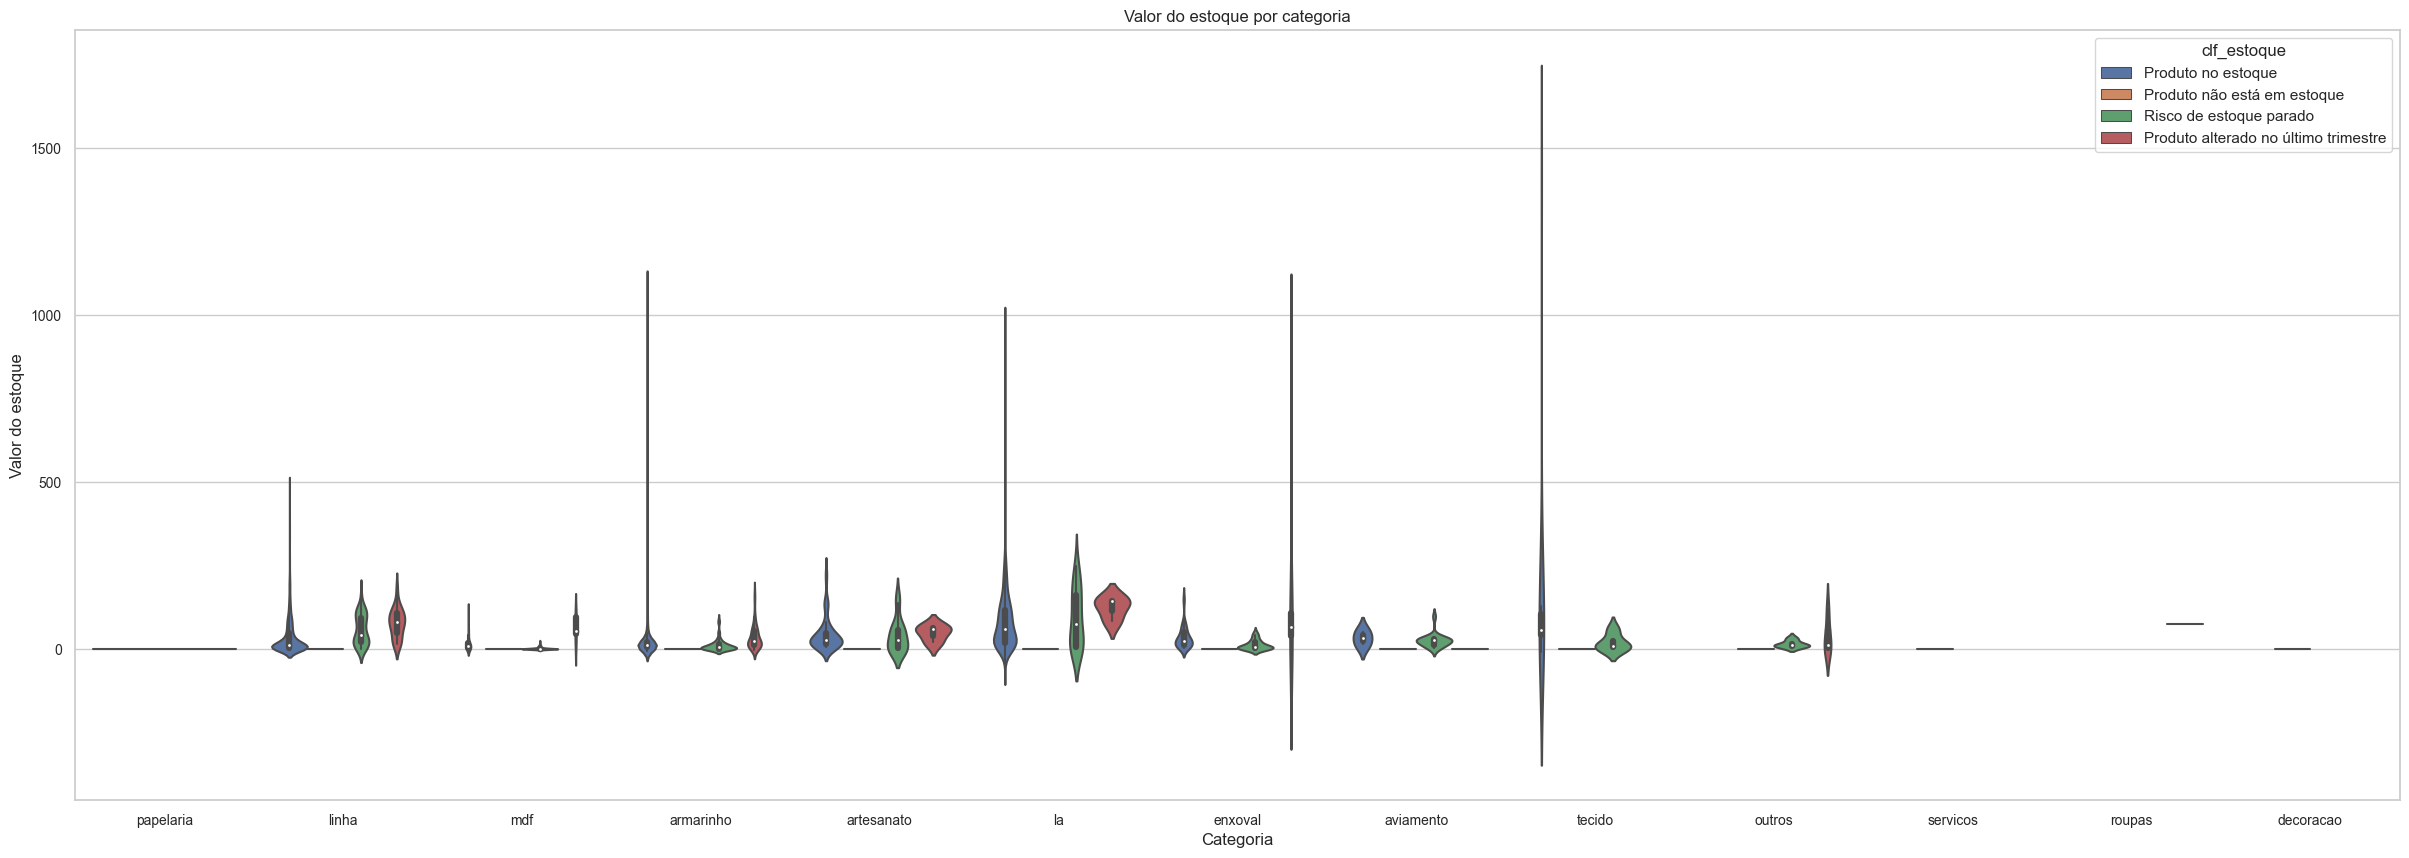

<Figure size 2000x2000 with 0 Axes>

In [45]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=5)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots()

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

b=sns.violinplot(x = 'categoria',y='valor_estoque_depreciado_corrigido', data=modelo_inventario, hue='clf_estoque')
b.set_xlabel('Categoria')
b.set_ylabel('Valor do estoque')
b.set_title('Valor do estoque por categoria')
plt.figure(figsize=(20,20))
plot_classificacao_inv.legend(loc='upper left')
plt.show()


In [47]:
#Rank de produtos em estoque por categoria com risco de estarem parados
top_10_fator_atualizacao_2 = modelo_inventario[modelo_inventario['fator_atualizacao'] == 1]
top_10_fator_atualizacao_2 = top_10_fator_atualizacao_2.sort_values(by=['fator_atualizacao'], ascending=False).groupby('clf_estoque')

top_10_fator_atualizacao_2[['categoria','descricao','estoque_disponivel','te_inicio_atualizacao','fator_atualizacao']].head(50)


categoria                                 descricao  estoque_disponivel  te_inicio_atualizacao  fator_atualizacao
1     papelaria  MASSA BISCUIT acrilex 90G - AMARELO PELE                 0.0                    397                1.0
2958      linha               BARBANTE TRENTO - CINZA 270                 0.0                    795                1.0
2754  armarinho               AGULHA CROCHÊ CIRCULO - 3,5                 0.0                    710                1.0
2753  armarinho                 AGULHA CROCHÊ CIRCULO - 3                 0.0                    710                1.0
2745  armarinho              AGULHA CROCHÊ  MILWARD 5,5mm                 0.0                      0                1.0
...         ...                                       ...                 ...                    ...                ...
1746  armarinho           RENDA GUIPEARE CHL 589 VERMELHO                13.7                      0                1.0
1745  armarinho           RENDA GUIPEARE CHL 589 ROSA 5CM                17.0                      0                1.0
1744  armarinho              RENDA GUIPEARE CHL 589 PRETA                27.4                      0                1.0
1743  armarinho            RENDA GUIPEARE CHL - 438 PRETA                13.7                      0                1.0
1742  armarinho                  RENDA GUIPEARE 9CM PRETO                 3.0                      0                1.0

[100 rows x 5 columns]

In [48]:
#g = sns.PairGrid(modelo_inventario, hue="categoria")
#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)
#g.add_legend()

In [49]:
#g = sns.PairGrid(modelo_inventario, hue="clf_estoque")
#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)
#g.add_legend()

In [50]:
#g = sns.PairGrid(modelo_inventario[modelo_inventario['clf_estoque'] == 'Risco de estoque parado'], hue='categoria')
#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)
#g.add_legend()

In [51]:
corr = modelo_inventario.corr()
corr.style.background_gradient(cmap='coolwarm')



Devido à baixa correlação presente na massa de dados, O trabalho passa a considerar os dados de Transação de produtos para a análise do modelo.



## DataFrame de Produtos

In [52]:
tipo_transf = modelo_transac_prod.tipo.unique()
tipo_transf

array(['Ajuste de Custo', 'Ajuste de Estoque +', 'Venda',
       'Ajuste de Estoque -', 'Devolução do Cliente'], dtype=object)

In [53]:
modelo_transac_prod['tipo'].value_counts()

Venda                   19997
Ajuste de Custo         13501
Ajuste de Estoque +      8984
Ajuste de Estoque -      4967
Devolução do Cliente        3
Name: tipo, dtype: int64

### Dados de Venda

In [54]:
modelo_transac_prod_vendas = modelo_transac_prod[modelo_transac_prod['tipo'] == 'Venda']
modelo_transac_prod_vendas['quant_'] = modelo_transac_prod_vendas['quant_']*-1
modelo_transac_prod_vendas


tipo  numero                    data                    hora                         produto  quant_  vl__unitario  sub_total  desconto  outras_despesas gerado_clf_auto  total          codigo  categoria
4      Venda   36767 2022-06-09 10:42:36.640 2022-06-09 10:42:36.640         PAPEL DECOUPAGE-AFQ-032     1.0           3.0        3.0      0.00                0               S   3.00        37013810  papelaria
5      Venda   36547 2022-06-03 09:31:31.703 2022-06-03 09:31:31.703             BASTIDOR MDF - 18CM     1.0           8.5        8.5      0.00                0               S   8.50        32968828        mdf
6      Venda   36426 2022-05-30 16:24:04.069 2022-05-30 16:24:04.069       FRALDA BOCA NICOLI - ROSA     2.0           4.8        9.6      0.00                0               S   9.60        30058838    enxoval
7      Venda   36392 2022-05-28 10:42:32.680 2022-05-28 10:42:32.680  AGULHA CROCHÊ ESMALTADA - 2,5M     1.0           7.0        7.0      0.22                0               S   6.78        18828463  armarinho
8      Venda   36367 2022-05-27 14:08:31.247 2022-05-27 14:08:31.247    AGULHA CROCHÊ MILWARD 5,5 mm     1.0           7.0        7.0      0.69                0               S   6.31        98947493  armarinho
...      ...     ...                     ...                     ...                             ...     ...           ...        ...       ...              ...             ...    ...             ...        ...
36476  Venda   11638 2020-09-13 16:46:32.133 2020-09-13 16:46:32.133             Linha Rayza - Lilás     2.0           8.5       17.0      0.00                0               N  17.00           98006      linha
36477  Venda   11637 2020-09-13 16:45:49.784 2020-09-13 16:45:49.784            COSTURA DRIMA - 6104     1.0           2.0        2.0      0.00                0               N   2.00         7099730      linha
36478  Venda   11637 2020-09-13 16:45:49.784 2020-09-13 16:45:49.784            COSTURA DRIMA - 5878     1.0           2.0        2.0      0.00                0               N   2.00  N126100-005876      linha
36479  Venda   11637 2020-09-13 16:45:49.784 2020-09-13 16:45:49.784              COSTURA DRIMA - PT     1.0           2.0        2.0      0.00                0               N   2.00          098930      linha
36480  Venda   11637 2020-09-13 16:45:49.784 2020-09-13 16:45:49.784          COSTURA DRIMA - Branca     1.0           2.0        2.0      0.00                0               N   2.00   N126100-0000B      linha

[19997 rows x 14 columns]

In [55]:
modelo_transac_prod_vendas = modelo_transac_prod_vendas.groupby(['numero','categoria','data']).agg({'quant_': 'sum','total':'sum'}).reset_index()
modelo_transac_prod_vendas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12172 entries, 0 to 12171
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   numero     12172 non-null  int64         
 1   categoria  12172 non-null  object        
 2   data       12172 non-null  datetime64[ns]
 3   quant_     12172 non-null  float64       
 4   total      12172 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 475.6+ KB


In [111]:
#modelo_transac_prod_vendas normalize quant_ field
modelo_transac_prod_vendas['qtd_norm'] = (modelo_transac_prod_vendas['quant_'] - modelo_transac_prod_vendas['quant_'].min())/ (modelo_transac_prod_vendas['quant_'].max() - modelo_transac_prod_vendas['quant_'].min())
modelo_transac_prod_vendas['data_dia'] = modelo_transac_prod_vendas['data'].dt.date
modelo_transac_prod_vendas['ano'] = modelo_transac_prod_vendas['data'].dt.year
modelo_transac_prod_vendas['mes'] = modelo_transac_prod_vendas['data'].dt.month


In [118]:
#ajustando o campo data para o formato datetime para poder fazer o agrupamento
modelo_transac_prod_vendas_diario = modelo_transac_prod_vendas[['numero','categoria','data_dia','ano','mes','quant_','qtd_norm','total']].sort_values(by=['data_dia'], ascending=True)

In [115]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
        print('ADF Statistic: %f' % dftest[0])
        print('p-value: %f' % dftest[1])
        print('Critical Values:')
        for key, value in dftest[4].items():
            print('\t%s: %.3f' % (key, value))

    else:
        print('The series is NOT stationary')
        print('ADF Statistic: %f' % dftest[0])
        print('p-value: %f' % dftest[1])
        print('Critical Values:')
        for key, value in dftest[4].items():
            print('\t%s: %.3f' % (key, value))
            

linha
The series is stationary
ADF Statistic: -29.496748
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


<Figure size 10400x8000 with 0 Axes>

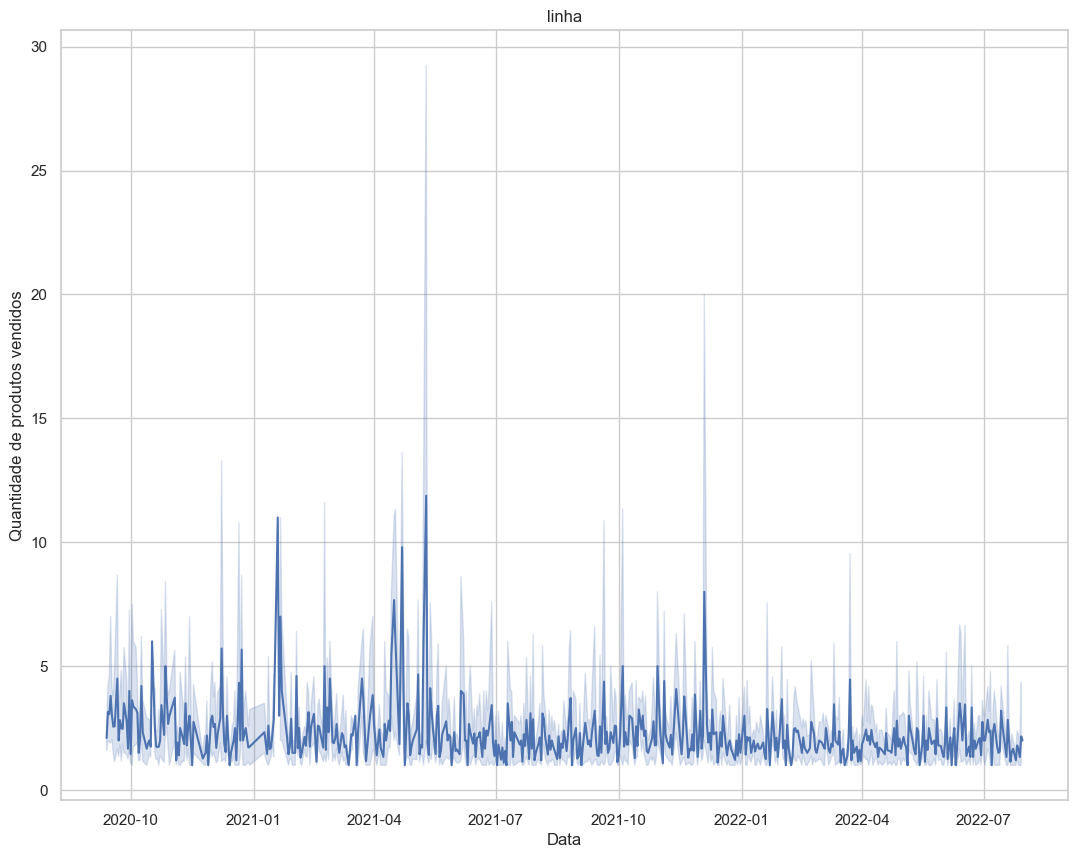

tecido
The series is stationary
ADF Statistic: -4.477912
p-value: 0.000216
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


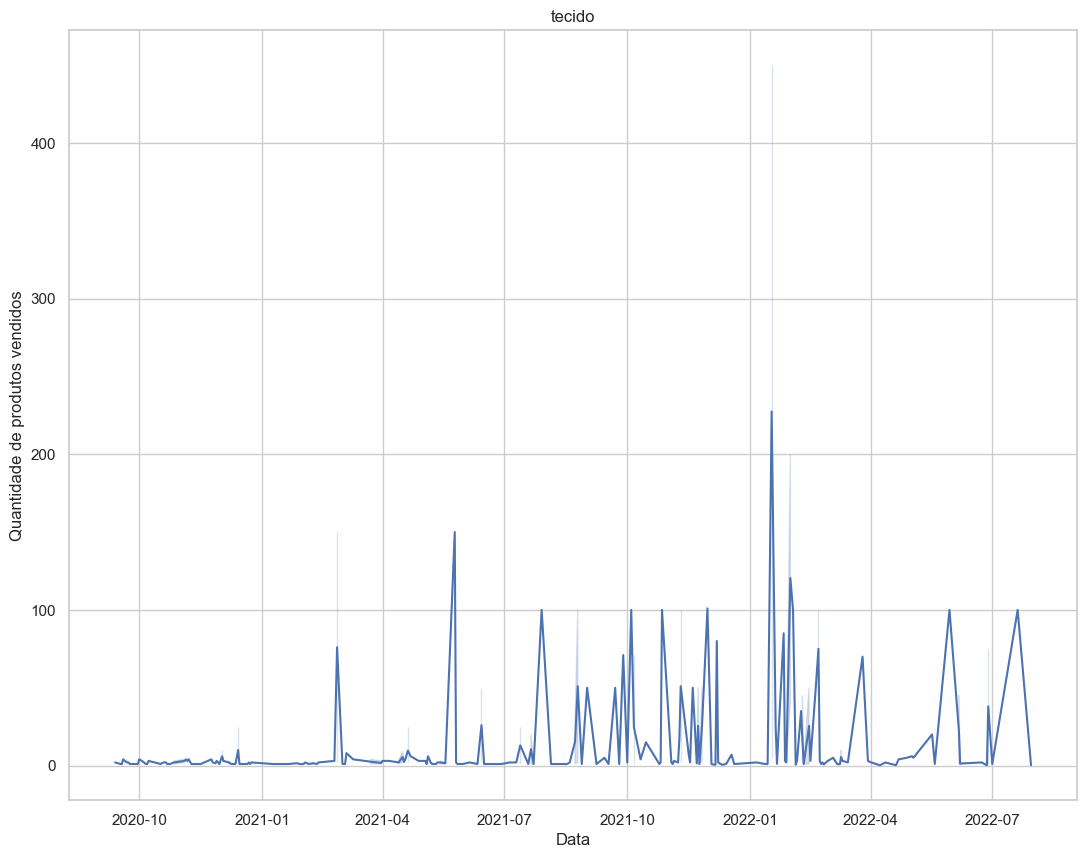

armarinho
The series is stationary
ADF Statistic: -11.764638
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


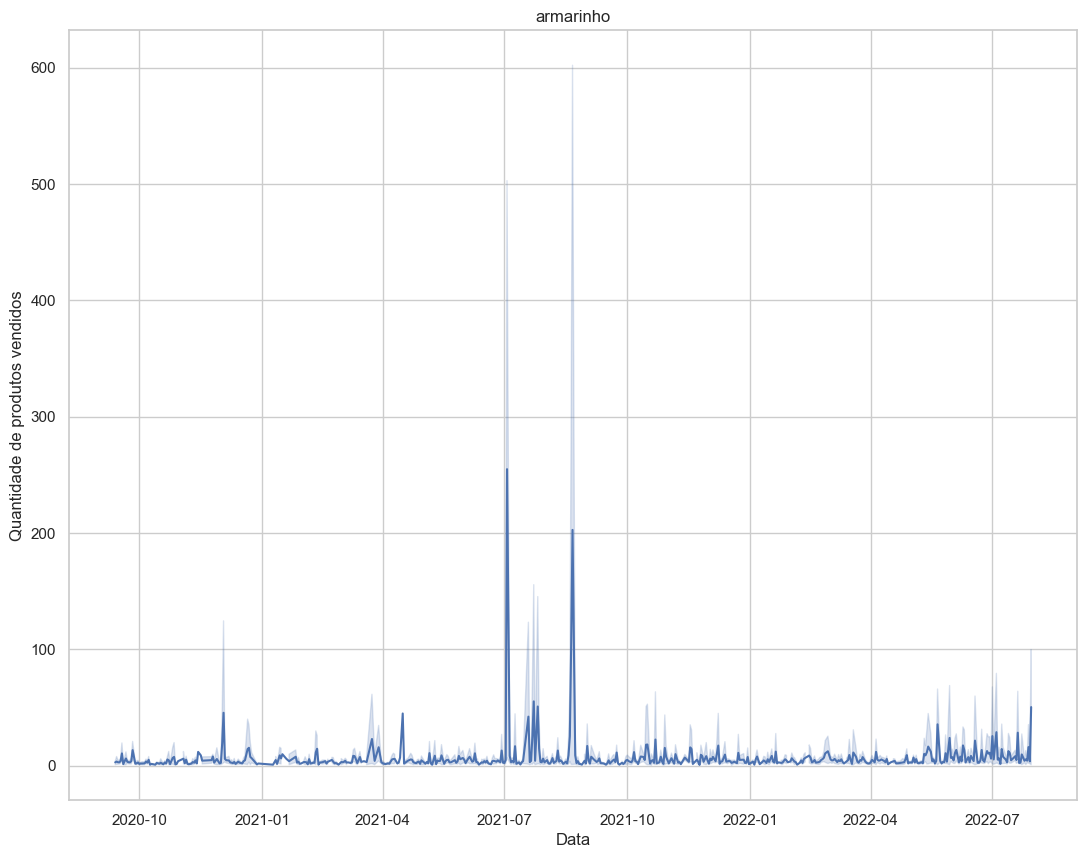

papelaria
The series is stationary
ADF Statistic: -4.926776
p-value: 0.000031
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


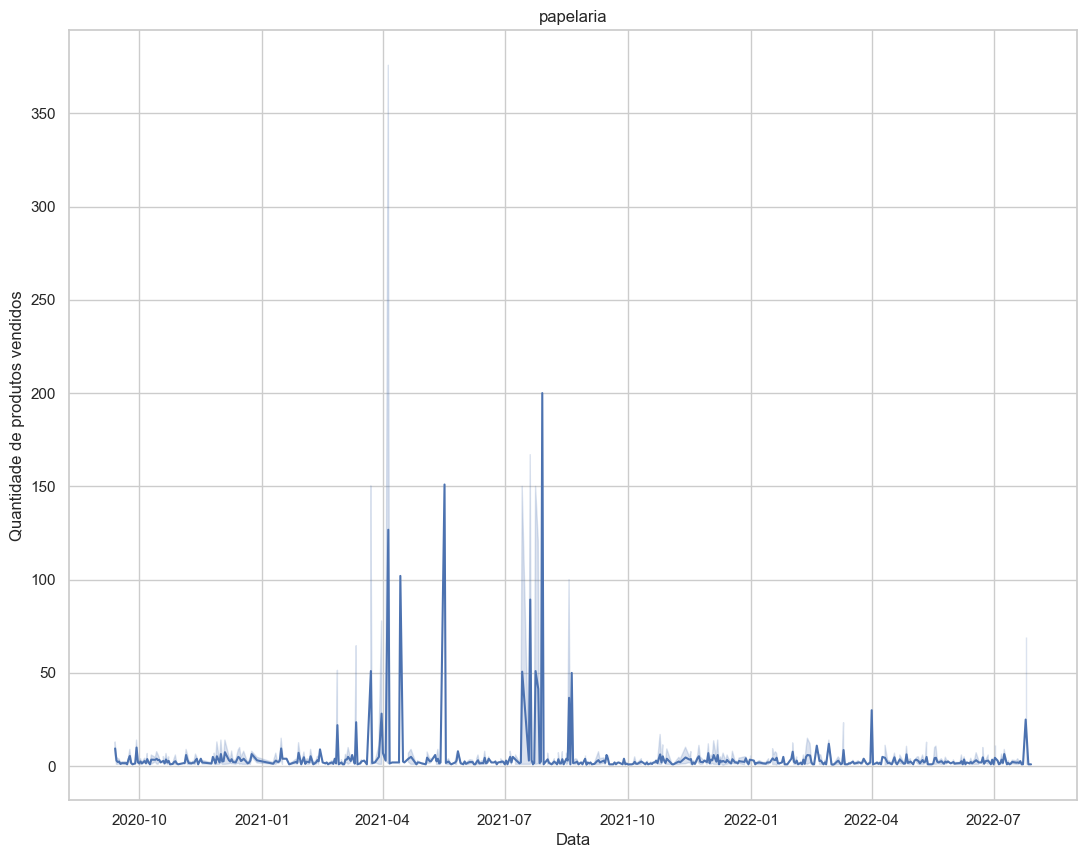

artesanato
The series is stationary
ADF Statistic: -6.157494
p-value: 0.000000
Critical Values:
	1%: -3.474
	5%: -2.881
	10%: -2.577


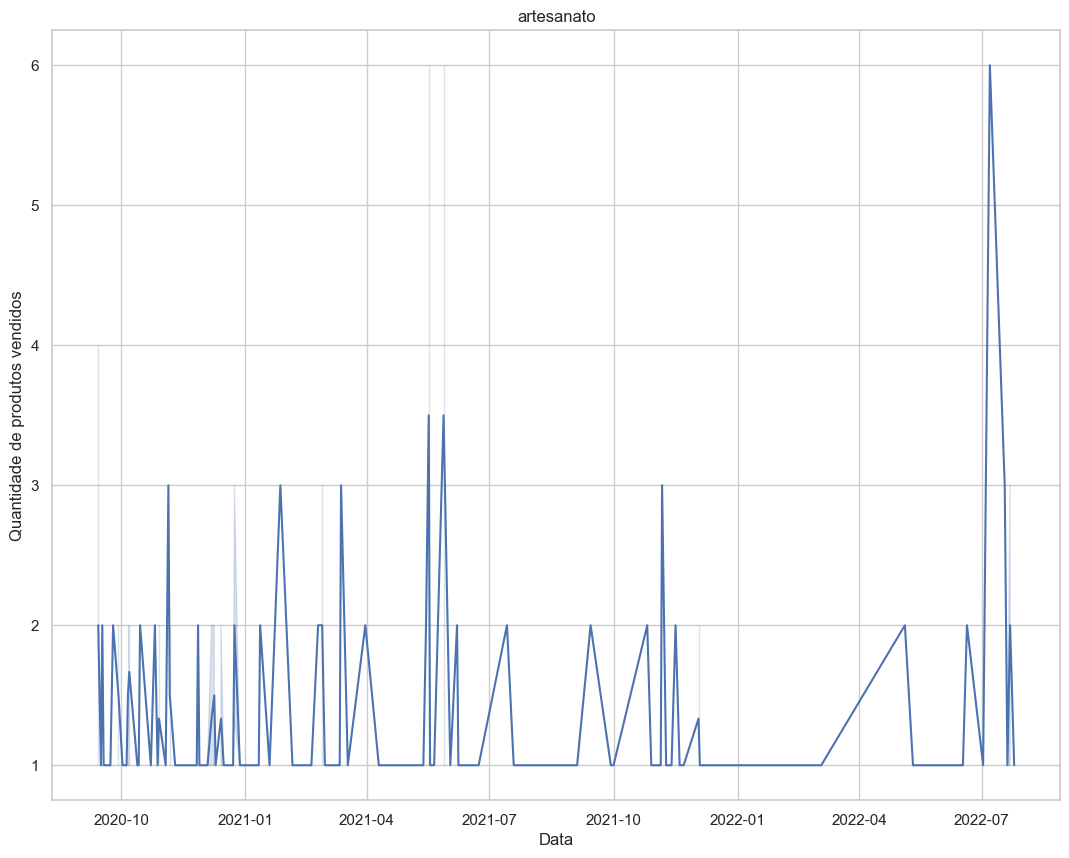

mdf
The series is stationary
ADF Statistic: -6.091149
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


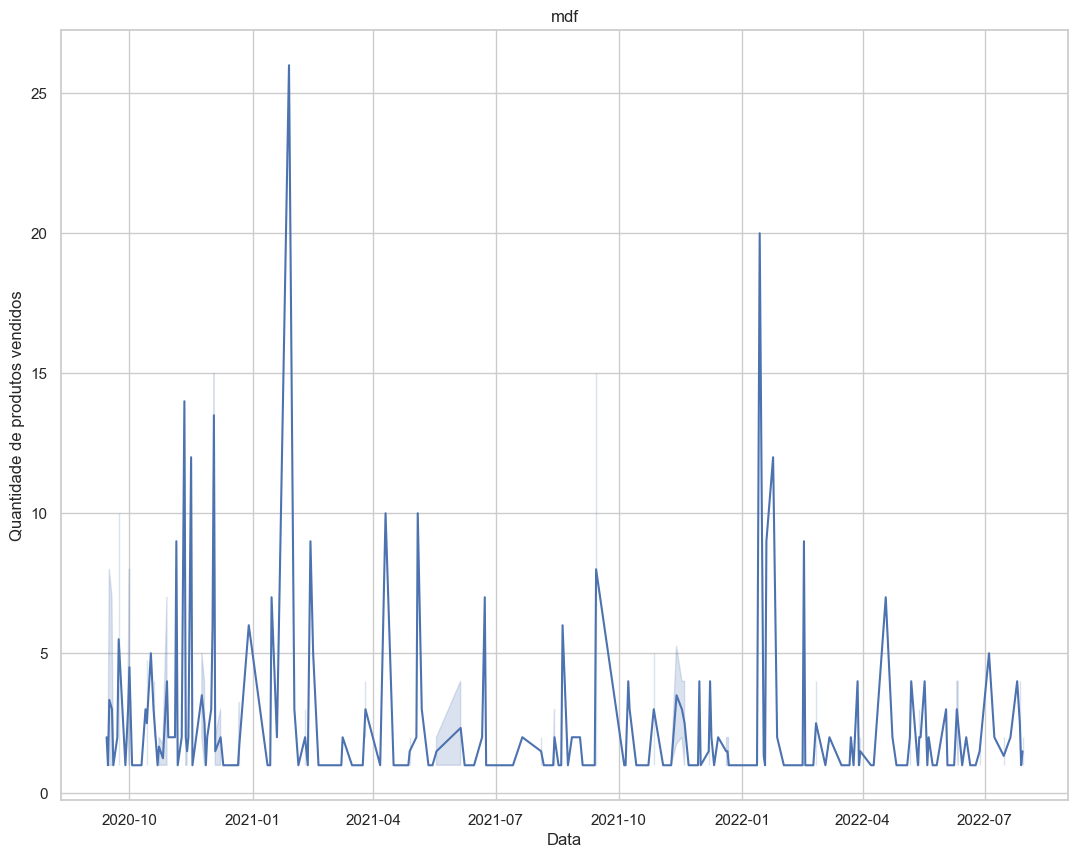

enxoval
The series is stationary
ADF Statistic: -7.258316
p-value: 0.000000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


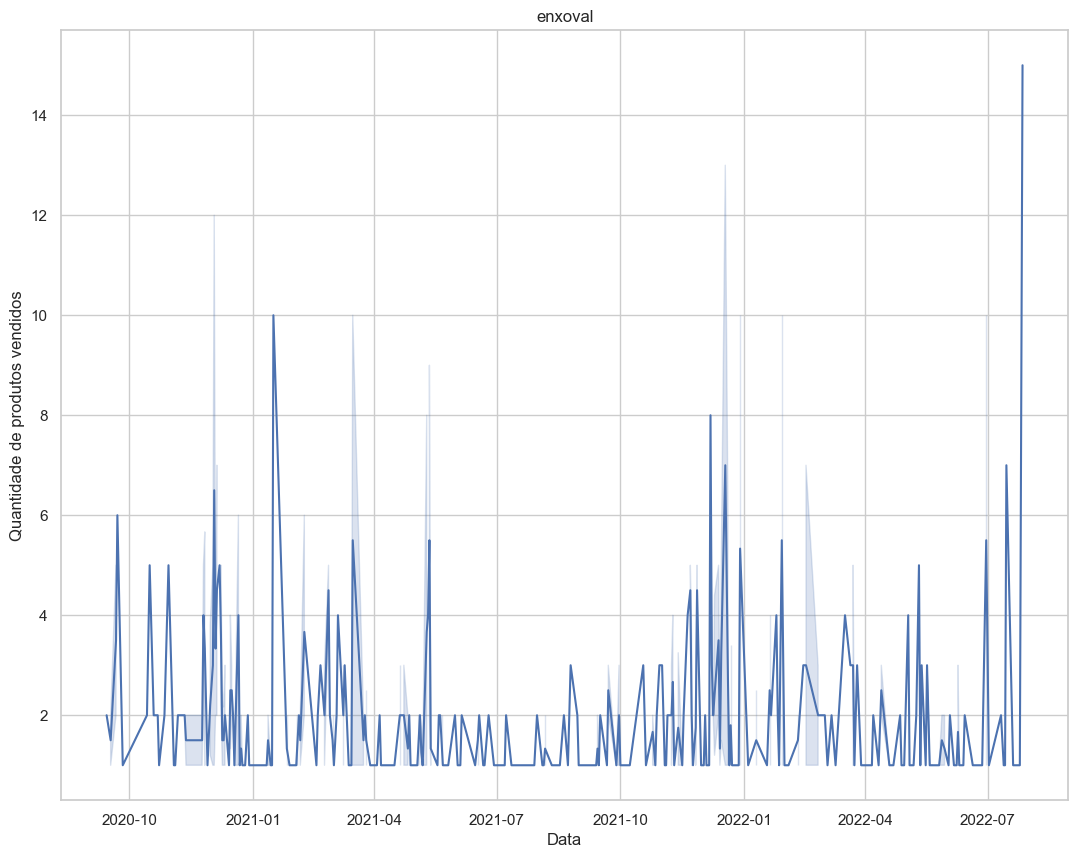

la
The series is stationary
ADF Statistic: -36.785207
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


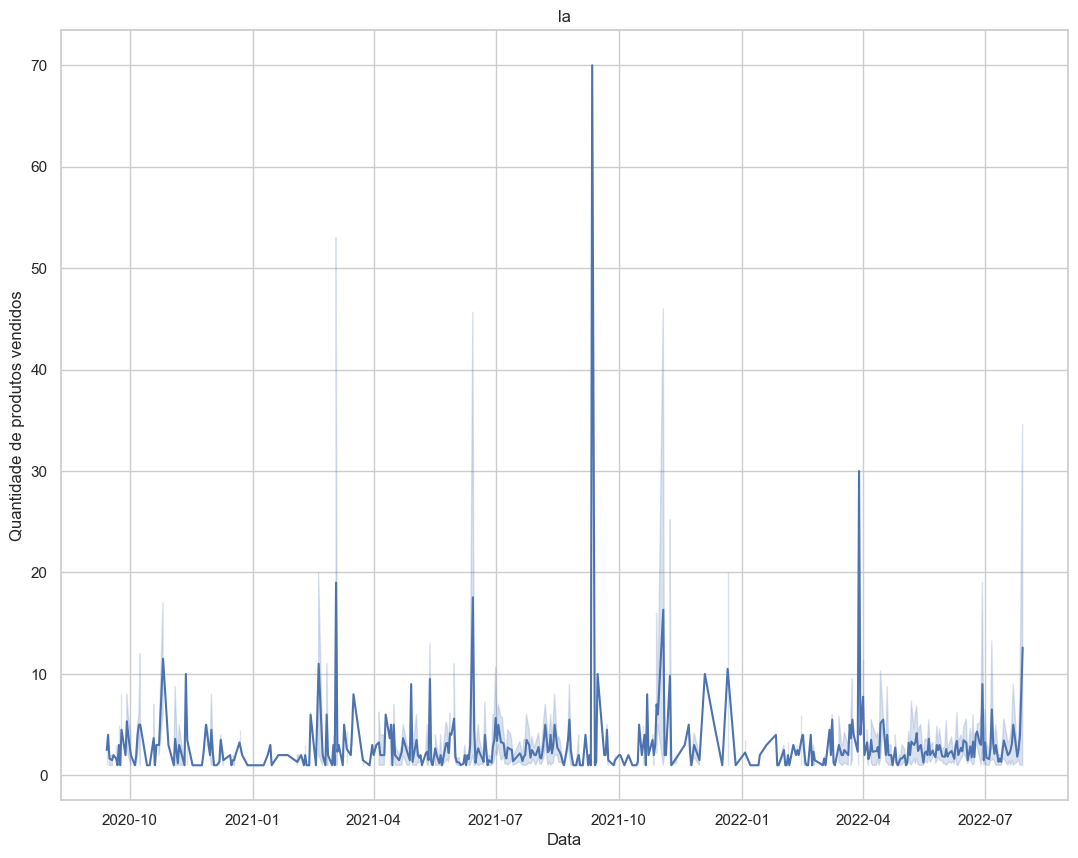

aviamento
The series is NOT stationary
ADF Statistic: -2.364196
p-value: 0.152098
Critical Values:
	1%: -3.964
	5%: -3.085
	10%: -2.682


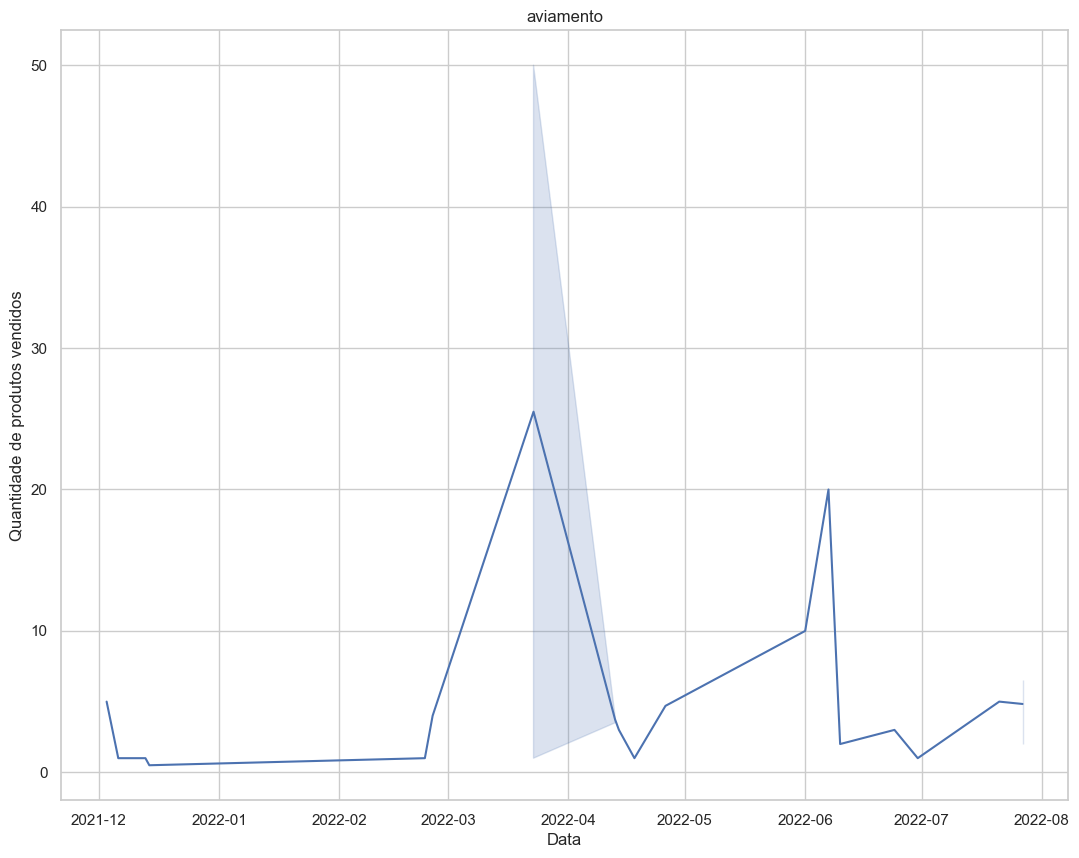

outros
The series is stationary
ADF Statistic: -3.912964
p-value: 0.001941
Critical Values:
	1%: -3.859
	5%: -3.042
	10%: -2.661


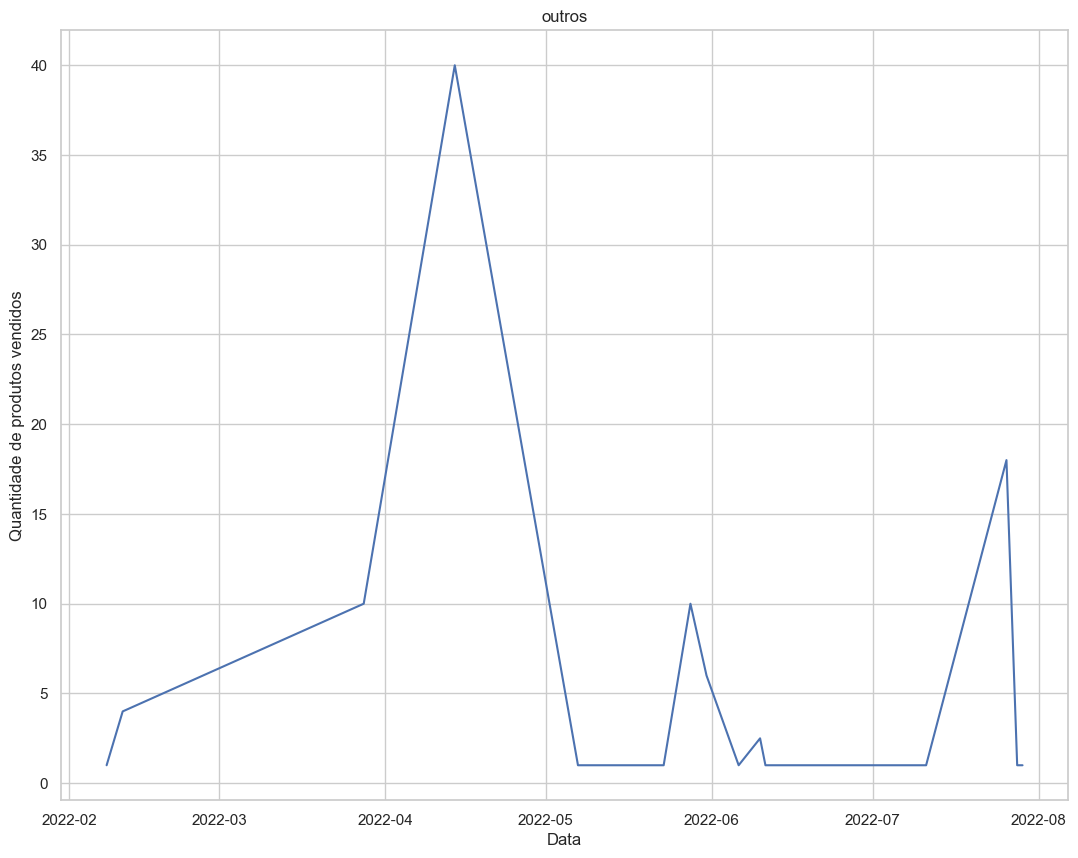

servicos
The series is NOT stationary
ADF Statistic: -2.295707
p-value: 0.173356
Critical Values:
	1%: -3.964
	5%: -3.085
	10%: -2.682


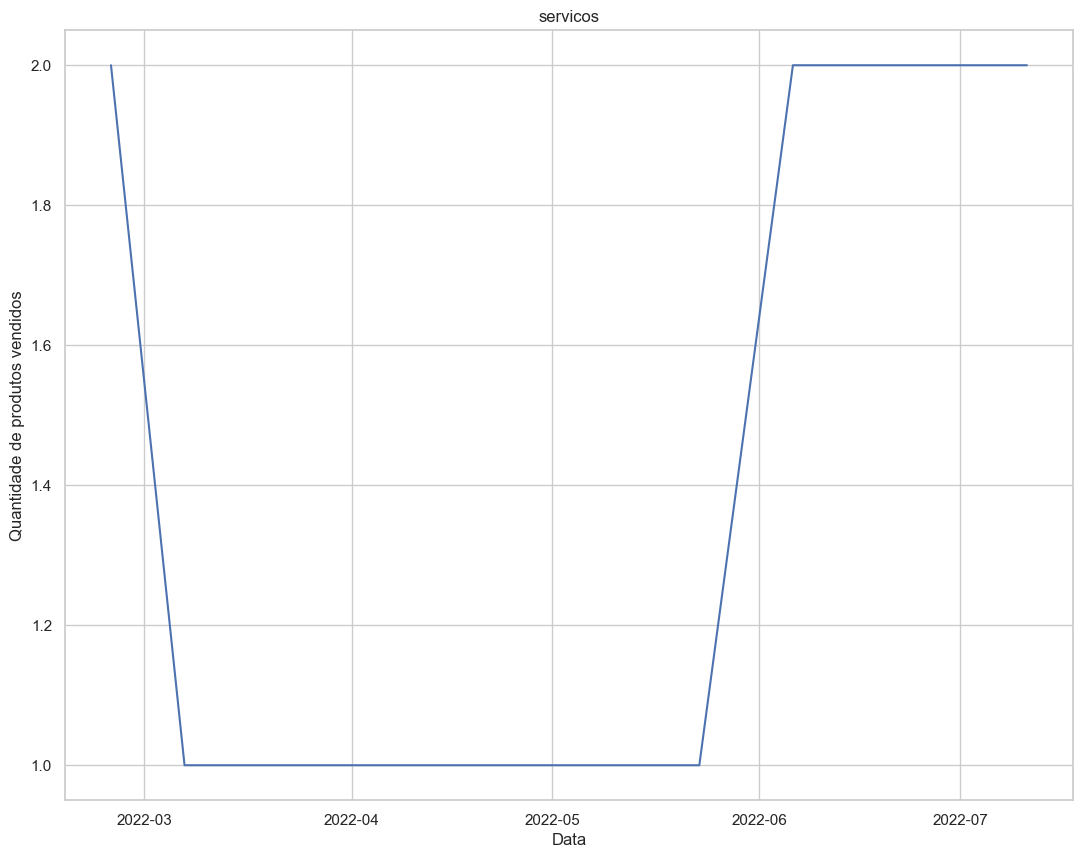

decoracao


ValueError: sample size is too short to use selected regression component

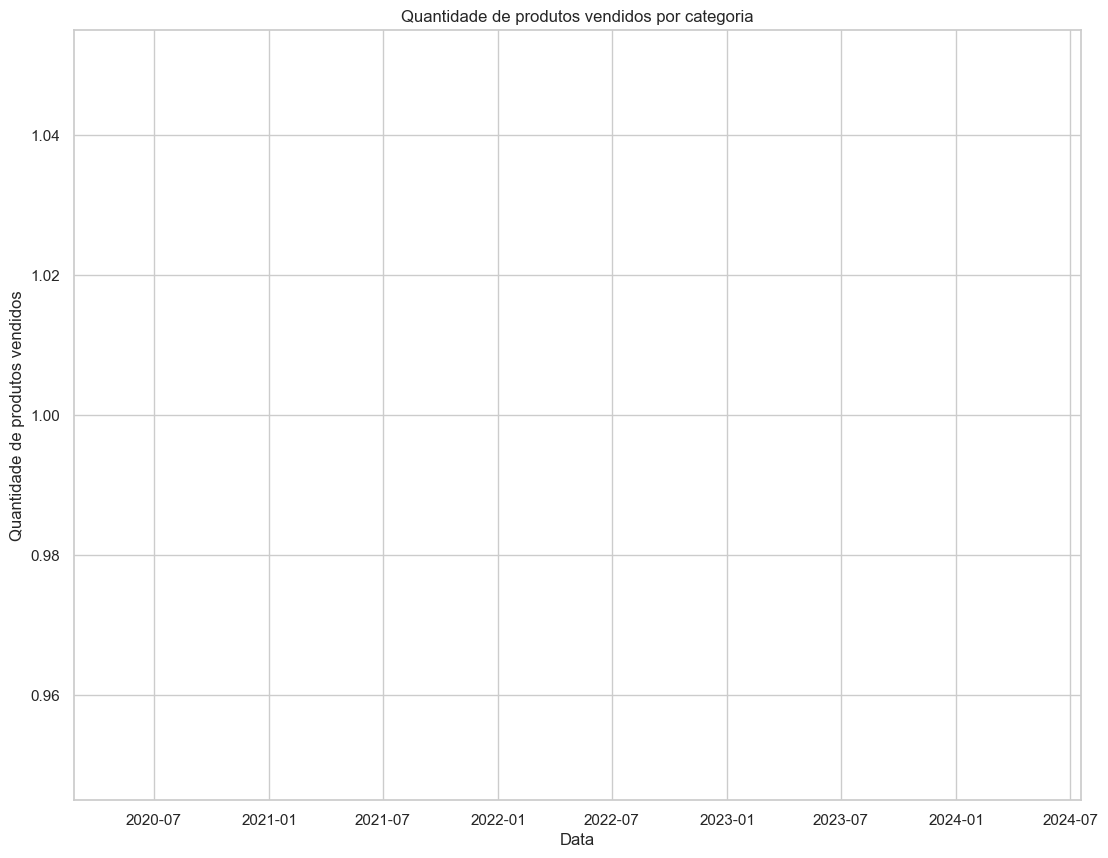

In [116]:
#sns timeplot hue categoria dataframe_transacoes_produto_tratado_2 by venda and data
from matplotlib.pyplot import figure

figure(figsize=(13, 10), dpi=800)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,10)
fig, ax = plt.subplots()
#create a time plot 
for categoria in modelo_transac_prod_vendas_diario['categoria'].unique():
    modelo_transac_prod_vendas_categoria =modelo_transac_prod_vendas_diario[modelo_transac_prod_vendas_diario['categoria'] == categoria]
    sns.lineplot(x='data_dia', y=(modelo_transac_prod_vendas_categoria['quant_']), data=modelo_transac_prod_vendas_diario)
    plt.title('Quantidade de produtos vendidos por categoria')
    plt.xlabel('Data')
    plt.ylabel('Quantidade de produtos vendidos')
    print(categoria)
    check_stationarity(modelo_transac_prod_vendas_categoria['quant_'])
    plt.title(categoria)
    plt.show()



In [107]:
figure(figsize=(35, 5), dpi=600)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (35,5)
sns.lineplot(x='data_dia', y='total', data=modelo_transac_prod_vendas_diario, hue='categoria', style='categoria',dashes=False, palette='bright', legend='full')
plt.title('Quantidade de produtos vendidos por categoria')
plt.xlabel('Data')
plt.ylabel('Quantidade de produtos vendidos')
plt.show()


In [120]:
modelo_transac_prod_vendas_diario_ajust = modelo_transac_prod_vendas_diario.query("categoria != 'roupas' | categoria != 'decoracao' | categoria != 'servicos' | categoria != 'outros' ")
modelo_transac_prod_vendas_diario_ajust

numero  categoria    data_dia   ano  mes  quant_  qtd_norm  total
0       11637      linha  2020-09-13  2020    9    4.00  0.003988   8.00
15      11654     tecido  2020-09-13  2020    9    2.00  0.001988  12.00
14      11651  armarinho  2020-09-13  2020    9    4.00  0.003988   0.80
12      11649  armarinho  2020-09-13  2020    9    4.00  0.003988   6.00
11      11648  armarinho  2020-09-13  2020    9    1.00  0.000988  10.00
...       ...        ...         ...   ...  ...     ...       ...    ...
12156   38237         la  2022-07-29  2022    7    1.00  0.000988   6.80
12170   38252  armarinho  2022-07-30  2022    7  100.00  0.099989  28.00
12168   38251  armarinho  2022-07-30  2022    7    1.00  0.000988   5.80
12169   38251      linha  2022-07-30  2022    7    2.00  0.001988   6.00
12171   38253     tecido  2022-07-30  2022    7    0.25  0.000238   6.97

[12172 rows x 8 columns]

<AxesSubplot:xlabel='ano', ylabel='total'>

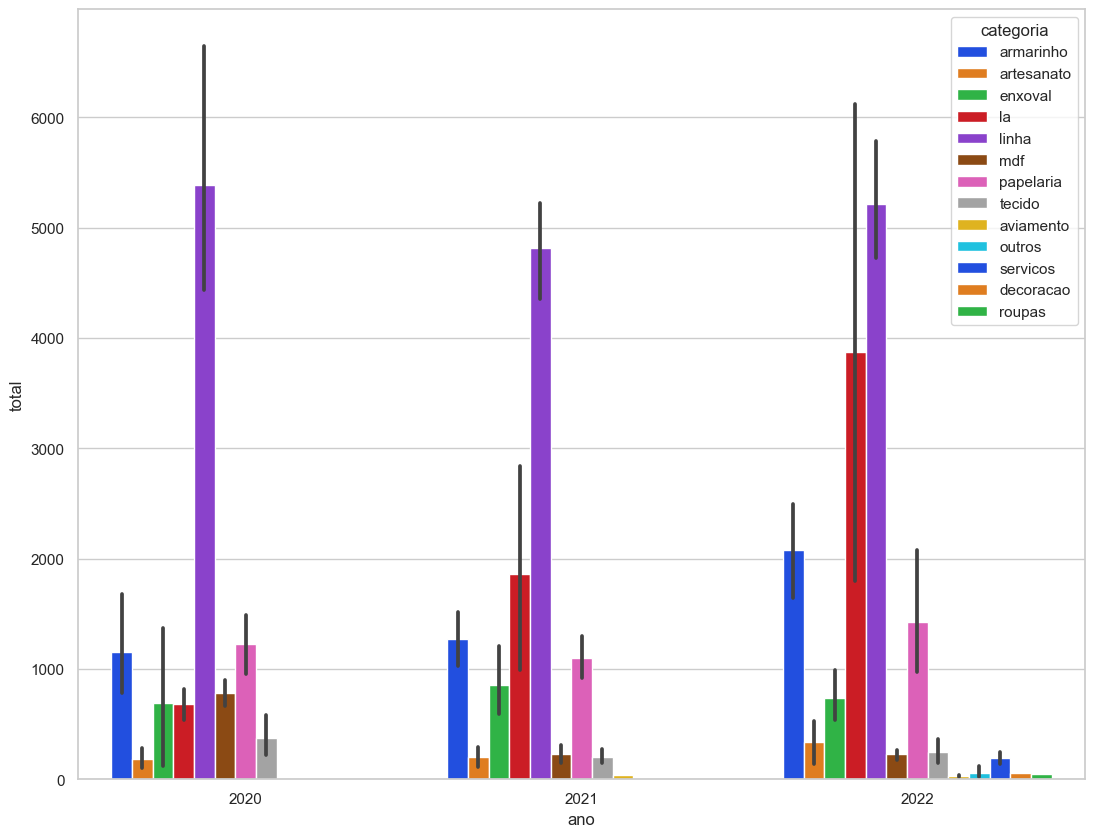

In [123]:
df = modelo_transac_prod_vendas_diario_ajust.groupby(['ano','mes','categoria']).agg({'quant_': 'sum','total':'sum'}).reset_index()
sns.barplot(x='ano', y='total', data=df, hue='categoria', palette='bright')

<AxesSubplot:xlabel='ano', ylabel='quant_'>

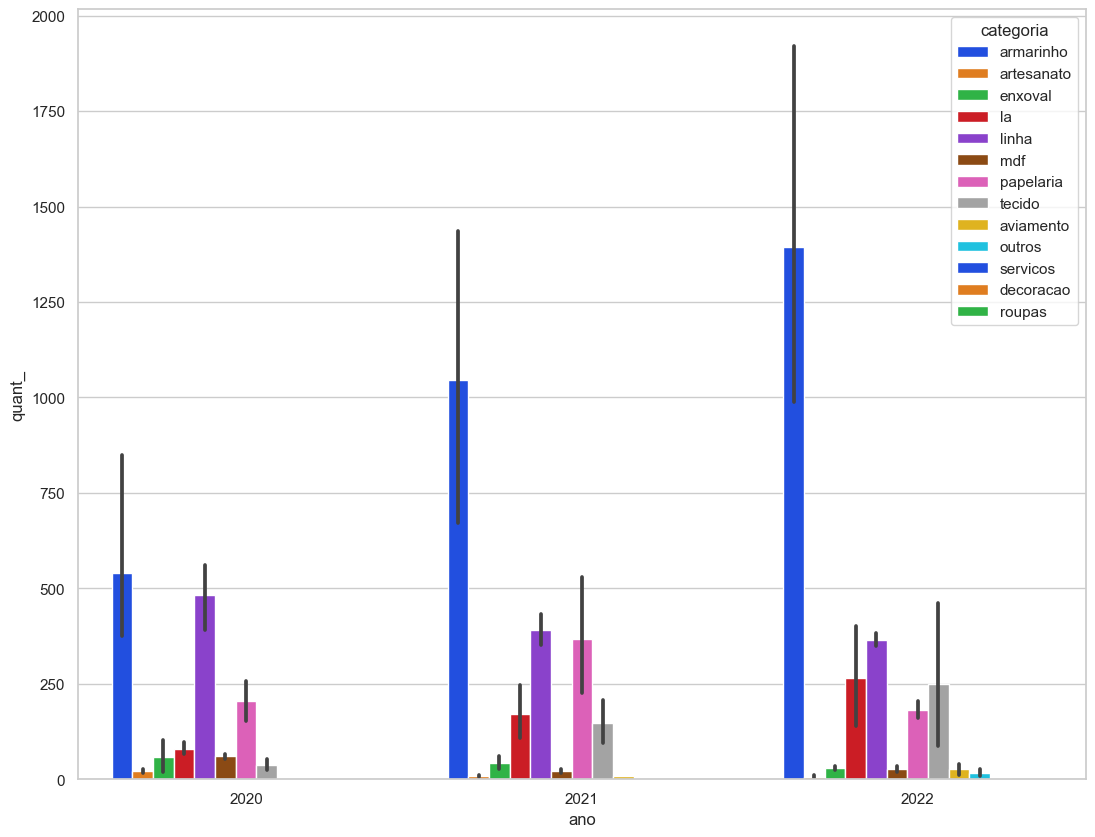

In [124]:
df = modelo_transac_prod_vendas_diario_ajust.groupby(['ano','mes','categoria']).agg({'quant_': 'sum','total':'sum'}).reset_index()
sns.barplot(x='ano', y='quant_', data=df, hue='categoria', palette='bright')